# Exploring NMF 

DS 5010 Text as Data

In [1]:
import pandas as pd
import numpy as np

In [2]:
from sklearn.decomposition import NMF

In [3]:
import plotly_express as px

# Set Up

## Config

In [4]:
import configparser
config = configparser.ConfigParser()
config.read('../../../env.ini')
data_home = config['DEFAULT']['data_home']
output_dir = config['DEFAULT']['output_dir']
local_lib = config['DEFAULT']['local_lib']

## Get Data

We work with data from Recino's Spanish translation of the Mayan _Popol Vuh_.

In [5]:
OHCO = ['parte','capit','sent','token']

In [6]:
DOC = pd.read_csv(f"{output_dir}/popolvuh/recinos-DOC.csv").set_index(OHCO[:2])
VOCAB = pd.read_csv(f"{output_dir}/popolvuh/recinos-VOCABX.csv").set_index('term_str')
TOKEN = pd.read_csv(f"{output_dir}/popolvuh/recinos-TOKEN.csv").set_index(OHCO)

We create a document-term matrix out of nouns, proper nouns, and verbs only.

We also exclude stopwords.

In [43]:
DTM = TOKEN[TOKEN.token_pos.isin(['NOUN','PROPN','VERB'])].groupby(OHCO[:2]+['term_str']).term_str.count().unstack(fill_value=0)
STOP = VOCAB[VOCAB.stop == True].index
DTM = DTM[list(set(DTM.columns) - set(STOP))]

# Compute NMF

Non-negative Matrix Factorization (NMF) is a **fast**, **interpretable**, and **purely analytical** dimensionality reduction technique. 

It factorizes a non-negative data matrix $V$ into two lower-rank non-negative matrices $W$ and $H$, such that $V \approx WH$.

LDA is epistemologically "stronger" in a sense, since it based on a model of how the data was generated.

But this comes at the cost of interpretability, tractability, and sometimes stability.


Here, we work with a small number of topics because (1) the book is relatively small for a corpus, and (2) we know the book has roughly five major parts, each devoted to a general theme.

In [66]:
n_topics = 6
nmf_engine = NMF(n_components=n_topics, max_iter=1000)

## THETA

In [67]:
THETA = pd.DataFrame(nmf_engine.fit_transform(DTM), index=DTM.index)

## PHI

In [68]:
PHI = pd.DataFrame(nmf_engine.components_, columns=DTM.columns)

## Topics

In [69]:
n_terms = 3
TOPIC = PHI.T.apply(lambda x: ', '.join(x.sort_values(ascending=False).head(n_terms).index)).T.to_frame('top_terms')

In [70]:
TOPIC

,top_terms
0,"senores, xibalba, casa"
1,"tohil, tribus, mahucutah"
2,"abuela, ixbalanque, hunahpu"
3,"casa, senores, generacion"
4,"tierra, cielo, hombre"
5,"muchachos, xibalba, flores"


Apply significance measures to the topics.

In [71]:
PHIN = PHI + .01 # We apply a smoothing factor to prevent division by zero errors

# Saliency
PW = PHIN.sum() / PHIN.sum().sum()
PTw = (PHIN / PHIN.sum()).T
PT = (PHIN.T.sum() / PHIN.T.sum().sum())
PHI_DST = PTw * np.log(PTw/PT)
PHI_SAL = PHI_DST.T * PW
TOPIC['top_sal'] = PHI_SAL.T.apply(lambda x: ', '.join(x.sort_values(ascending=False).head(n_terms).index)).T

# Relevance
λ = .5
PHI_REL = λ * np.log(PHIN) + (1 - λ) * np.log(PHIN/PW)
TOPIC['top_rel'] = PHI_REL.T.apply(lambda x: ', '.join(x.sort_values(ascending=False).head(n_terms).index)).T

In [72]:
TOPIC

,top_terms,top_sal,top_rel
0,"senores, xibalba, casa","xibalba, senores, huncame","xibalba, huncame, senores"
1,"tohil, tribus, mahucutah","tohil, tribus, mahucutah","tohil, tribus, mahucutah"
2,"abuela, ixbalanque, hunahpu","abuela, hermanos, hunchouen","abuela, hermanos, hunchouen"
3,"casa, senores, generacion","generacion, casa, reyes","generacion, reyes, casas"
4,"tierra, cielo, hombre","tierra, cielo, creador","tierra, cielo, creador"
5,"muchachos, xibalba, flores","muchachos, flores, zipacna","muchachos, flores, zipacna"


# View Topics over Narrative Time

We check to see if the topics match the narrative structure of the story.

In [73]:
THETA.columns = TOPIC.top_sal

In [74]:
px.imshow(THETA[THETA > .3].fillna(0).T.values, 
    x = [str(idx)[1:-1].replace(", ", ":") for idx in THETA.index.to_list()],
    y = THETA.columns.to_list(),
    height=300, width=1000,
    color_continuous_scale=px.colors.sequential.Greens)

It does so nicely.

# Cluster Documents in Topic Space

In [75]:
import sys
sys.path.append(local_lib)

In [76]:
from hac2 import HAC

In [77]:
metric = 'euclidean' # "euclidean", "l1", "l2", "manhattan", "cosine", or "precomputed"
linkage = 'ward' # 'ward', 'complete', 'average', 'single'

In [78]:
fig1 = HAC(THETA)
fig1.linkage_method = linkage
fig1.dist_metric = metric

In [79]:
# fig1.color_thresh = 2.5 # w/o verbs
fig1.color_thresh = 2

<Figure size 640x480 with 0 Axes>

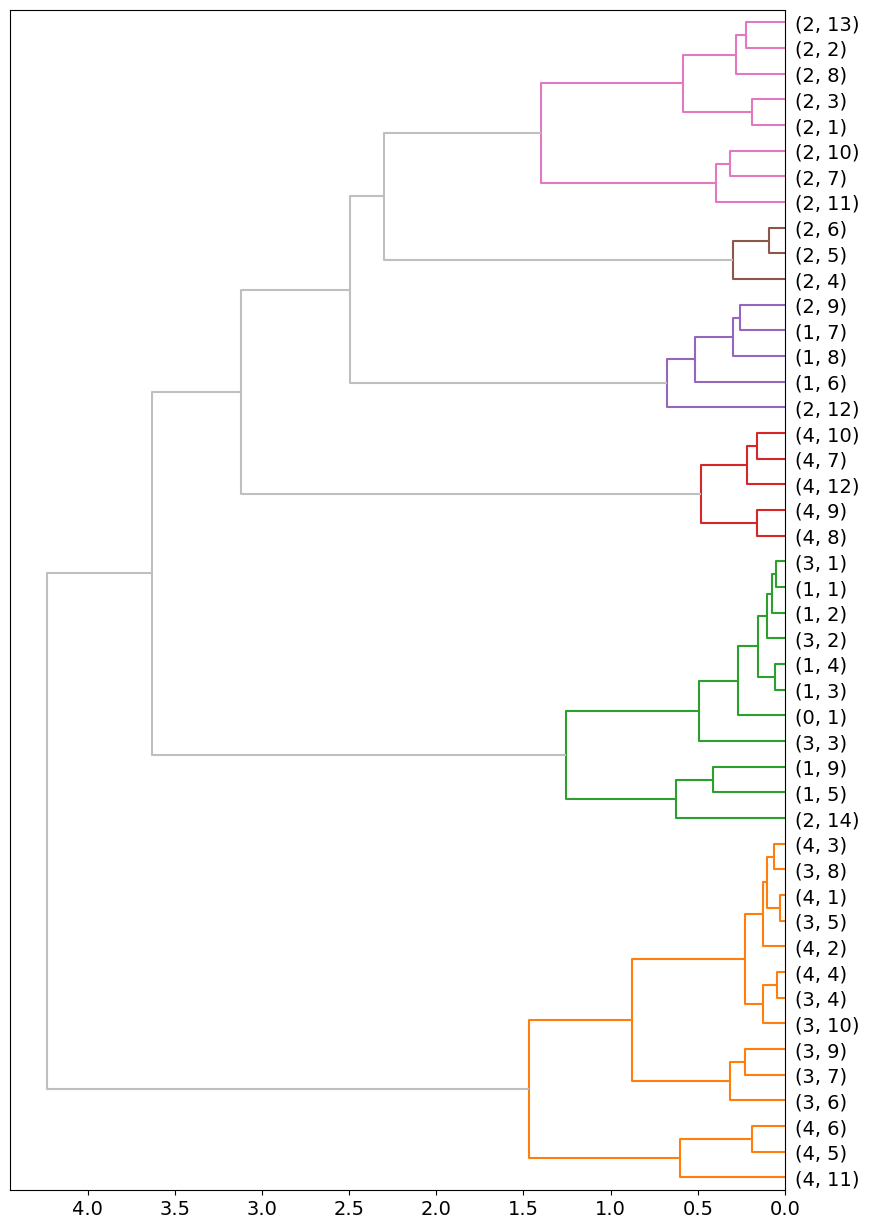

In [80]:
fig1.plot()

In [81]:
label_color = {
    '1': 'orange',
    '2': 'limegreen',
    '3': 'red',
    '4': 'violet',
    '5': 'tan',
    '6': 'orange',
    '7': 'purple',
    '8': 'fuscha',
    '9': 'limegreen',
    '': 'white'
}

In [82]:
fig1.get_cluster_labels()
DOC['topic_group'] = fig1.CLUSTER_LABELS
DOC.topic_group = DOC.topic_group.astype(str)

In [83]:
DOC.topic_group.unstack(fill_value='')\
    .style.map(lambda x: 'background:' + label_color[x])

capit,1,2,3,4,5,6,7,8,9,10,11,12,13,14
parte,,,,,,,,,,,,,,
0,2,,,,,,,,,,,,,
1,2,2,2,2,2,4,4,4,2,,,,,
2,6,6,6,5,5,5,6,6,4,6,6,4,6,2
3,2,2,2,1,1,1,1,1,1,1,,,,
4,1,1,1,1,1,1,3,3,3,3,1,3,,


## Compare to previous clusters

In [84]:
DOC.value_counts(['label','topic_group']).unstack(fill_value=0).style.background_gradient(cmap="YlGnBu", axis=None)

topic_group,1,2,3,4,5,6
label,,,,,,
1,0,1,0,2,3,8
2,0,5,0,0,0,0
3,0,3,0,3,0,0
4,1,0,5,0,0,0
5,13,2,0,0,0,0


In [85]:
DOC[['label','topic_group']].corr('spearman').iloc[0,1]

-0.8561129389895522

# Correlate Documents in Topic Space

In [86]:
X = THETA.T.corr()

In [87]:
labels = [str(x[0]).zfill(2) + ':' + str(x[1]).zfill(2) for x in X.index.values]

In [88]:
px.imshow(X.values, x = labels,y = labels,
        height=1000, width=1200,
        color_continuous_scale=px.colors.diverging.Spectral)

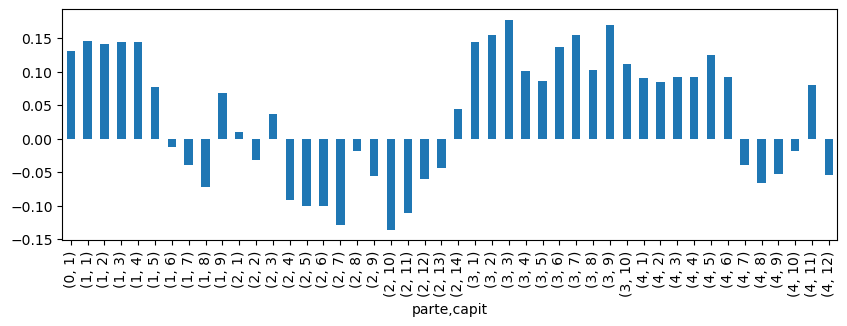

In [107]:
X.mean().plot.bar(figsize=(10,3));

# Cluster Documents in Correlation Space

In [90]:
fig2 = HAC(X)
fig2.linkage_method = linkage
fig2.dist_metric = metric

In [91]:
# fig2.color_thresh = 2.5 # w/o verbs
fig2.color_thresh = 1.5

<Figure size 640x480 with 0 Axes>

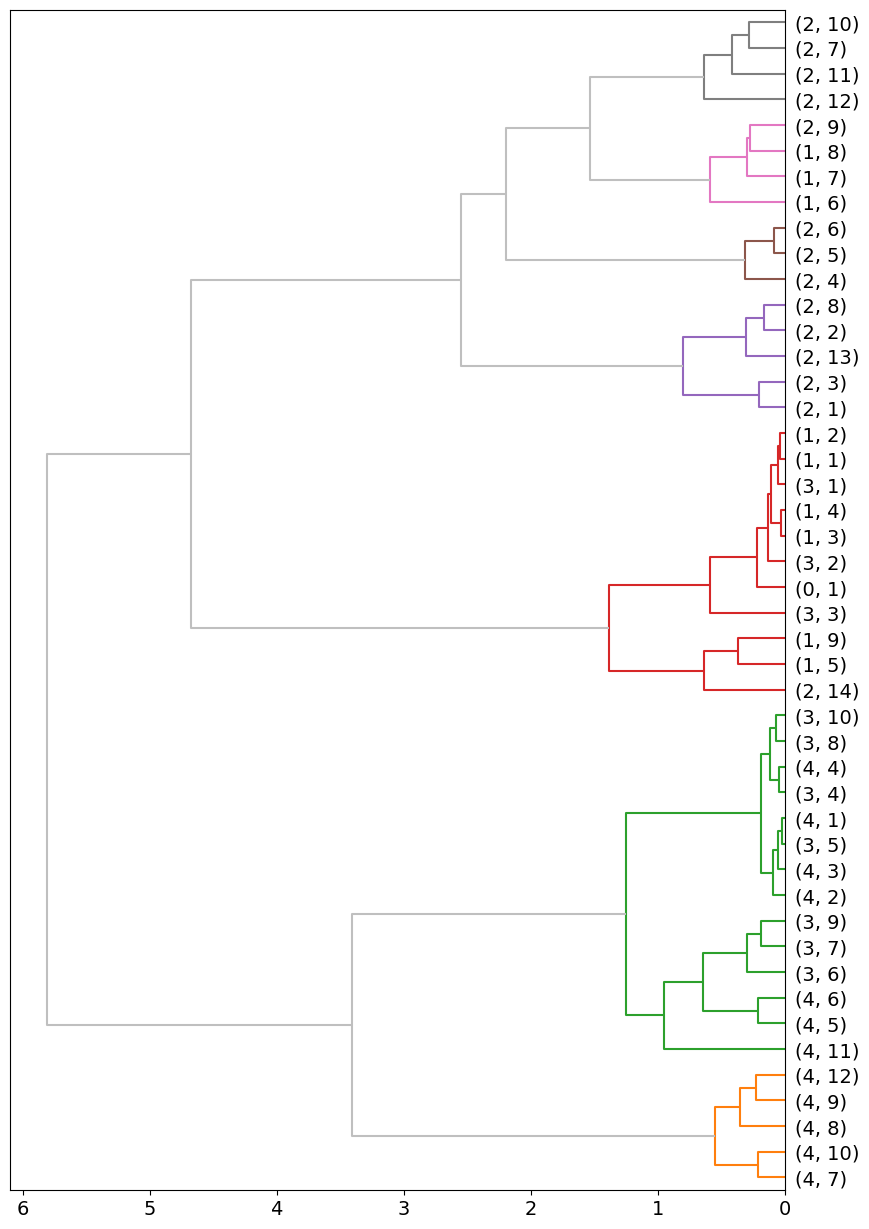

In [92]:
fig2.plot()

In [93]:
fig2.get_cluster_labels()
DOC['topic_group2'] = fig2.CLUSTER_LABELS
DOC.topic_group2 = DOC.topic_group2.astype(str)

In [94]:
DOC.topic_group2.unstack(fill_value='')\
    .style.map(lambda x: 'background:' + label_color[x])

capit,1,2,3,4,5,6,7,8,9,10,11,12,13,14
parte,,,,,,,,,,,,,,
0,3,,,,,,,,,,,,,
1,3,3,3,3,3,6,6,6,3,,,,,
2,4,4,4,5,5,5,7,4,6,7,7,7,4,3
3,3,3,3,2,2,2,2,2,2,2,,,,
4,2,2,2,2,2,2,1,1,1,1,2,1,,


# Correlate Topics in Word Space

In [95]:
PHI.T.corr().style.background_gradient(cmap="YlGnBu")

,0,1,2,3,4,5
0,1.000000,0.101055,0.223220,0.310788,0.077201,0.284141
1,0.101055,1.000000,0.062036,0.141010,0.115813,0.061212
2,0.223220,0.062036,1.000000,0.067106,0.138364,0.223558
3,0.310788,0.141010,0.067106,1.000000,0.084718,0.017893
4,0.077201,0.115813,0.138364,0.084718,1.000000,0.063762
5,0.284141,0.061212,0.223558,0.017893,0.063762,1.000000


In [101]:
TOPIC

,top_terms,top_sal,top_rel
0,"senores, xibalba, casa","xibalba, senores, huncame","xibalba, huncame, senores"
1,"tohil, tribus, mahucutah","tohil, tribus, mahucutah","tohil, tribus, mahucutah"
2,"abuela, ixbalanque, hunahpu","abuela, hermanos, hunchouen","abuela, hermanos, hunchouen"
3,"casa, senores, generacion","generacion, casa, reyes","generacion, reyes, casas"
4,"tierra, cielo, hombre","tierra, cielo, creador","tierra, cielo, creador"
5,"muchachos, xibalba, flores","muchachos, flores, zipacna","muchachos, flores, zipacna"


In [102]:
R = PHI.T.corr().stack().to_frame('r')
R.index.names = ['topic_a', 'topic_b']
R = R.query("topic_a < topic_b")

In [103]:
# R.sort_values('r', ascending=False).style.bar(color='violet')

In [104]:
R2 = pd.concat([R.reset_index(), 
           R.reset_index().topic_a.map(TOPIC.top_sal).to_frame('a_terms'), 
           R.reset_index().topic_b.map(TOPIC.top_sal).to_frame('b_terms')], axis=1)\
    .set_index(['topic_a','topic_b']).sort_values('r', ascending=False)

In [105]:
R2.style.bar(color='violet')